In [1]:
import uproot
import ROOT
import numpy as np
import pandas as pd
from collections import OrderedDict

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['patch.linewidth'] = 1.5

Welcome to JupyROOT 6.14/02


In [2]:
def extract_teffi(eff):
    _ = ROOT.TCanvas()
    eff.Draw()
    ROOT.gPad.Update()
    
    tot = eff.GetTotalHistogram()
    nBins = tot.GetNbinsX()
    xx = []
    yy = []
    yl = []
    yu = []
    for i in range(1, nBins+1):
        if eff.GetEfficiency(eff.GetGlobalBin(i)) == 0 and eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i)) == 1.: continue
        if eff.GetEfficiency(eff.GetGlobalBin(i)) == 1. and eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)) == 1.: continue
        
        xx.append(tot.GetXaxis().GetBinCenter(i))
        yy.append(eff.GetEfficiency(eff.GetGlobalBin(i)))
        yl.append(eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)))
        yu.append(eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i)))
                  
    
    return {'x': np.array(xx),
            'y': np.array(yy),
            'yerr': np.array([yl, yu])}

In [3]:
# tree = uproot.open('../Firefighter/washAOD/test/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2_100k.root')['RECO_muTrackEffi/recoEffiForMuTrack']
# df = tree.pandas.df()

dfs = OrderedDict({
    0.1 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-1p20e-03_100k.root')['RECO_dsa/recoEffiForMuTrack'].pandas.df(),
      1 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-0p012_100k.root'   )['RECO_dsa/recoEffiForMuTrack'].pandas.df(),
     10 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-0p12_100k.root'    )['RECO_dsa/recoEffiForMuTrack'].pandas.df(),
     50 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-0p6_100k.root'     )['RECO_dsa/recoEffiForMuTrack'].pandas.df(),
    100 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2_100k.root'     )['RECO_dsa/recoEffiForMuTrack'].pandas.df(),
    300 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-3p6_100k.root'     )['RECO_dsa/recoEffiForMuTrack'].pandas.df()
})

In [4]:
for k, df in dfs.items():
    df.columns = [x.decode() for x in df.columns]

0.1      76856
1.0      76891
10.0     76585
50.0     76831
100.0    75585
300.0    59282
dtype: int64

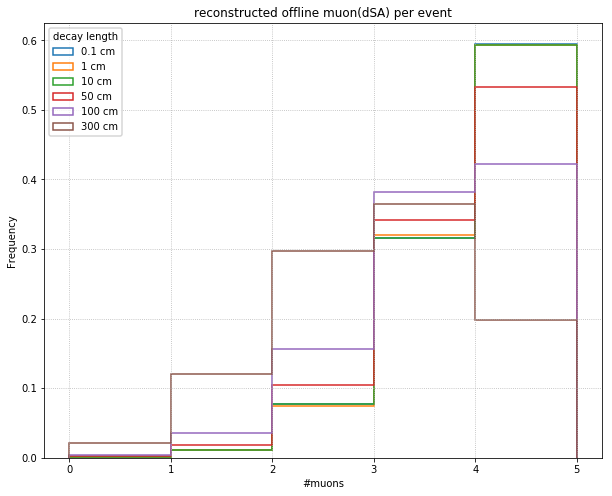

In [7]:
fig, ax = plt.subplots(figsize=(10,8))

nevents = {}
for k, df in dfs.items():
    df['nMatched'].plot.hist(bins=5, range=(0,5), ax=ax, label=f'{k} cm', histtype='step', density=True)
    nevents[k] = len(df['nMatched'].dropna())

ax.set_xlabel('#muons')
ax.grid()
plt.title('reconstructed offline muon(dSA) per event')
plt.legend(loc='upper left', title='decay length')
pd.Series(nevents)

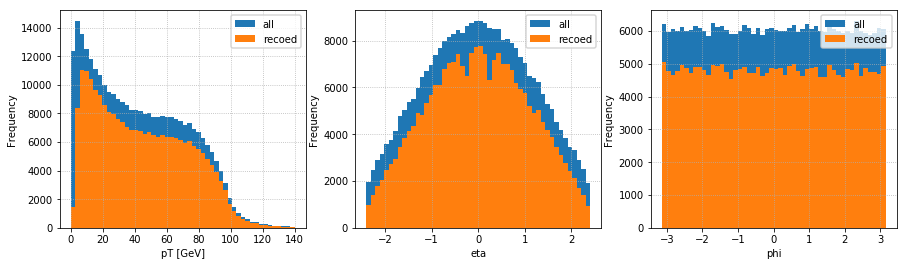

In [8]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

df = dfs[100]

recoDf = df[['genPt','genEta','genPhi', 'recoPt']].dropna()

df['genPt']    .plot.hist(bins=50, range=(0,140), ax=ax[0], label='all')
recoDf['genPt'].plot.hist(bins=50, range=(0,140), ax=ax[0], label='recoed')
ax[0].set_xlabel('pT [GeV]')

df['genEta']    .plot.hist(bins=50, range=(-2.4,2.4), ax=ax[1], label='all')
recoDf['genEta'].plot.hist(bins=50, range=(-2.4,2.4), ax=ax[1], label='recoed')
ax[1].set_xlabel('eta')

df['genPhi']    .plot.hist(bins=50, ax=ax[2], label='all')
recoDf['genPhi'].plot.hist(bins=50, ax=ax[2], label='recoed')
ax[2].set_xlabel('phi')

for a in ax:
    a.legend(loc='best')
    a.grid()

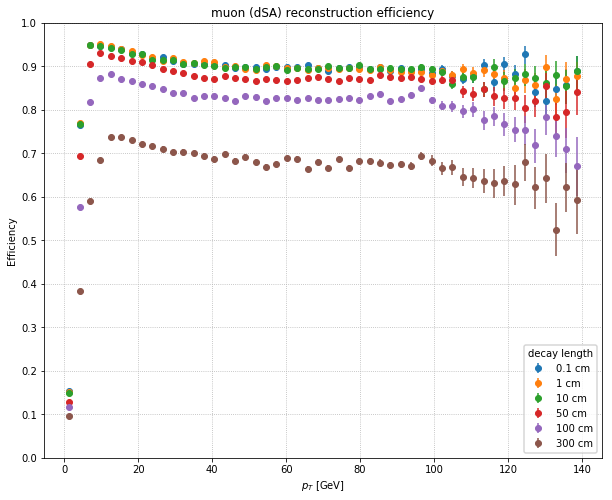

In [13]:
fig,ax = plt.subplots(figsize=(10,8))
# df = dfs[1]
for k, df in dfs.items():
    recoDf = df[['genPt', 'recoPt']].dropna()
    h0 = ROOT.TH1F(f'h0_{k}', '', 50,0,140)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50,0,140)
    for x in df['genPt']: h0.Fill(x)
    for x in recoDf['genPt']: h1.Fill(x)
    
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} cm')

ax.set_title('muon (dSA) reconstruction efficiency')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

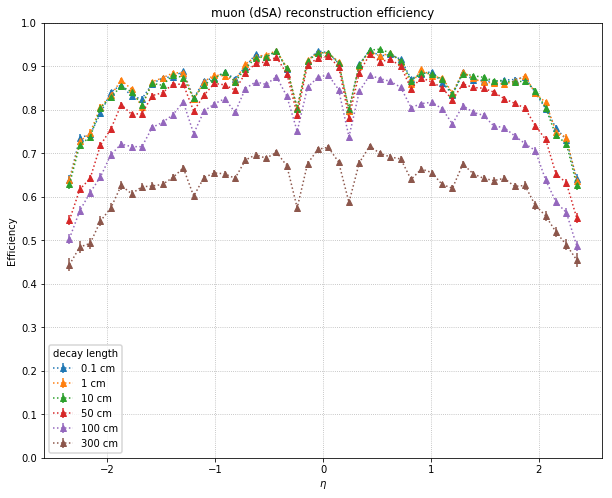

In [10]:
fig,ax = plt.subplots(figsize=(10,8))

for k, df in dfs.items():
    recoDf = df[['genEta', 'recoEta']].dropna()
    h0 = ROOT.TH1F(f'h0_{k}', '', 50,-2.4,2.4)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50,-2.4,2.4)
    for x in df['genEta']: h0.Fill(x)
    for x in recoDf['genEta']: h1.Fill(x)
    
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='^:', label=f'{k} cm')

ax.set_title('muon (dSA) reconstruction efficiency')
ax.set_xlabel('$\eta$')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

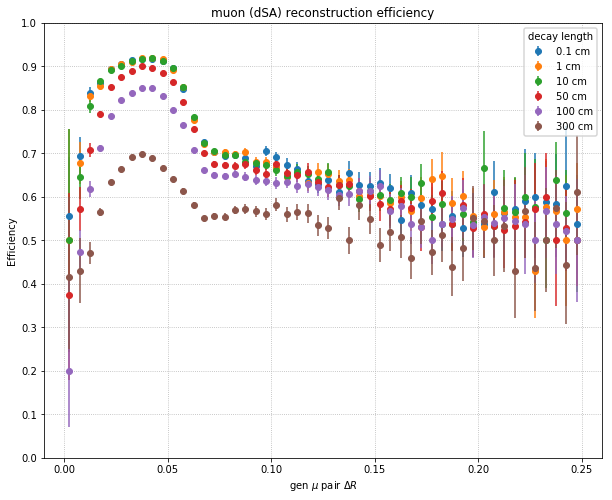

In [11]:
fig,ax = plt.subplots(figsize=(10,8))

for k, df in dfs.items():
    recoDf = df[['genDr', 'recoEta']].dropna()
    h0 = ROOT.TH1F(f'h0_{k}', '', 50,0,0.25)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50,0,0.25)
    for x in df['genDr']: h0.Fill(x)
    for x in recoDf['genDr']: h1.Fill(x)
    
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} cm')

ax.set_title('muon (dSA) reconstruction efficiency')
ax.set_xlabel('gen $\mu$ pair $\Delta R$')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

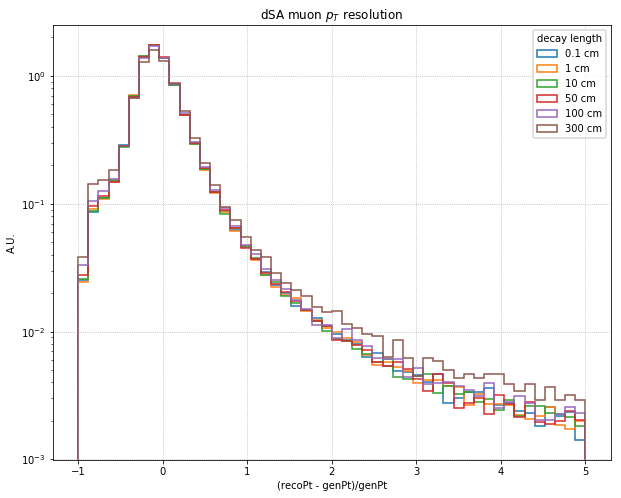

In [12]:
fig,ax = plt.subplots(figsize=(10,8))
# df = dfs[1]
for k, df in dfs.items():
    recoDf = df[['genPt', 'recoPt']].dropna()
    recoDf['reso'] = (recoDf['recoPt'] - recoDf['genPt']) / recoDf['genPt']
    recoDf['reso'].plot.hist(bins=50,range=(-1.,5), label=f'{k} cm', histtype='step',density=True)

ax.set_title('dSA muon $p_{T}$ resolution')
ax.set_xlabel('(recoPt - genPt)/genPt')
ax.set_ylabel('A.U.')
ax.set_yscale('log')
ax.legend(loc='best', title='decay length')
ax.grid()